# Demo 2: Convolutional Neural Network (CNN)
This demo we will demo code for using CNN to solve the classification problem:
-   Problem: Surface defect classification (Binary classification)
-   Dataset: DCV81 A_surface dataset
    -   Train folder:
        -   A1 folder: Defect surface (17 images) 
        -   Good folder: Good surface (30 images)
    -   Val folder:
        -   A1 folder: Defect surface (6 images) 
        -   Good folder: Good surface (10 images)
    -   Test folder:
        -   A1 folder: Defect surface (6 images) 
        -   Good folder: Good surface (10 images)
-   Library packages:
    -   Numpy (Numpy arrays are very fast and can perform large computations in a very short time)
    -   PIL (Simple image processing package: read, show, resize,...)
    -   Matplotlib (Plot package: visualize result,....)
    -   TensorFlow (This is an open-source library that is used for DL/ML/AI)
    -   Scikit-Learn (Machine Learning models: KNN,SVM,Decision Tree, Metrics,...)

Tasks Outlines:
## 0. Task 0: Preparing dataset
-   Downloads dataset, unpacking dataset,...
-   Transform it to input (features) and ouput (labels) where the model in tensorflow library can read, and training on,...
-   Normalize or standardlize dataset (we may do it after some evaluations on the raw data)
-   Divide dataset to trainset and testset (maybe one more validation_set)
## 1. Task 1: Constructing model by using TensorFlow library:
-   Create a convolutional neural network for classification problem
-   Training model on our trainset and applying the early stopping during the training
## 2. Task 2: Evaluating the performance of trained model on the testset
-   Predict the label (which class) for each input image in the testset
-   Compute the metrics (quantitative measurements) 
    -   For example on Classification task: Accuracy, Precesion, Recall, Confusion Matrix, F1-Score, Cross-Entropy Loss,...
## 3. Task 3: Training model with data augmentation, save the best model, loading the trained model.
-   Training model train data_augmentation
-   Loading the trained model and evaluating on the test set.
*****************************************************************************

## Import all packages

In [36]:
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPool2D, Activation
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn import metrics

## 0. Task 0: Preparing Dataset

### 0.1. Define a function get all paths to each image in the dataset and the class label of each image

In [2]:
def get_all_img_label_path(input_dir:str,
                            img_suffix = '.bmp')->(list,list):
    """
    parameters:
    -   input_dir: the directory to the data folder
    -   img_suffix: siffix type of image in the data folder to read
    output: a tuple of two lists:
    -   List of all path to each image in the data folder
    -   List of relative class for each image in the data folder
    """
    label_to_number = {"Good":0,"A1":1}
    list_img_paths = []
    list_labels = []
    for root,dirs,files in os.walk(input_dir):
        for file in files:
            file_path = os.path.join(root,file)

            file_name,file_suffix = os.path.splitext(file)
            if file_suffix == img_suffix:
                list_img_paths.append(file_path)
                folder_name = os.path.basename(os.path.dirname(file_path))
                list_labels.append(label_to_number[folder_name])
    return (list_img_paths,list_labels)

In [3]:
# Resize the image to small dimensional of width and height
def get_data(list_img_paths:list,
             list_labels:list,
             is_resize:bool= True,
             width:int = 32,
             height:int = 32) -> (np.array,np.array):
    """
    Parameters:
    -   list_img_paths: List of all paths to image in the data folder
    -   list_labels: The list of labels relative to each image in the list_img_paths
    -   is_resize: Default is True means resize all image in the dataset
        to the new size (width,height)
    -   width: The width size which we want to resize to
    -   height: The height size which we want to resize to

    Output: A tuple of two arrays
    -   data_array with shape (N,h,w), where
        -   N is the number of image
        -   h is the height
        -   w is the width
    -   label_array with shape (N,)
    """
    data = []
    for i in range(len(list_img_paths)):
        path_img = list_img_paths[i]
        img = Image.open(path_img).convert('L')
        if is_resize:
            img = img.resize(size = (width,height),
                            resample=Image.BICUBIC)
        data.append(np.array(img))
    return (np.array(data),np.array(list_labels))

In [4]:
# Setting for image shape
width = 32*2
height = 32*2
n_channels = 1

In [5]:
# Get the list images path and list labels of train, val, test
train_dir = "D:\\APPLY_JOB_2023\\Data\\ASink\\A_20240118\\Data_CNN\\Train"
val_dir = "D:\\APPLY_JOB_2023\\Data\\ASink\\A_20240118\\Data_CNN\\Val"
test_dir = "D:\\APPLY_JOB_2023\\Data\\ASink\\A_20240118\\Data_CNN\\Test"

list_imgs_train,list_labels_train = get_all_img_label_path(input_dir=train_dir,
                                                    img_suffix='.bmp')
list_imgs_val,list_labels_val = get_all_img_label_path(input_dir=val_dir,
                                                    img_suffix='.bmp')
list_imgs_test,list_labels_test = get_all_img_label_path(input_dir=test_dir,
                                                    img_suffix='.bmp')

In [6]:
X_train,label_train = get_data(list_img_paths=list_imgs_train,
               list_labels=list_labels_train,
               is_resize=True,
               width=width,
               height= height)

X_val,label_val = get_data(list_img_paths=list_imgs_val,
               list_labels=list_labels_val,
               is_resize=True,
               width=width,
               height= height)

X_test,label_test = get_data(list_img_paths=list_imgs_test,
               list_labels=list_labels_test,
               is_resize=True,
               width=width,
               height= height)

In [7]:
print(X_train.shape)

(47, 64, 64)


In [8]:
n_samples_train = X_train.shape[0]
X_train = X_train.reshape((n_samples_train,height,width,n_channels))
X_train = X_train/255
y_train = to_categorical(label_train)

In [9]:
n_samples_val = X_val.shape[0]
X_val = X_val.reshape((n_samples_val,height,width,n_channels))
X_val = X_val/255
y_val = to_categorical(label_val)

In [10]:
n_samples_test = X_test.shape[0]
X_test = X_test.reshape((n_samples_test,height,width,n_channels))
X_test = X_test/255
y_test = to_categorical(label_test)

In [37]:
# define the input_shape
input_shape = (height,width,n_channels)
# Define the model CNN
model_cnn = Sequential()
## Convolution layer1 : Conv2d => MaxPool2D => Dropout
model_cnn.add(Conv2D(32,
                    kernel_size=(5,5),
                    input_shape = input_shape))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPool2D(pool_size=(2,2)))
model_cnn.add(Dropout(0.2))
## Convolution layer2 : Conv2d => MaxPool2D => Dropout
model_cnn.add(Conv2D(16,
                    kernel_size=(3,3),
                    input_shape = input_shape))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPool2D(pool_size=(2,2)))
model_cnn.add(Dropout(0.2))
## Fully-Connected layers:
model_cnn.add(Flatten())
model_cnn.add(Dense(128,activation='relu'))
model_cnn.add(Dense(2,activation='softmax'))

In [38]:
# Showo the model summary
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        832       
                                                                 
 activation (Activation)     (None, 60, 60, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 30, 30, 32)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 16)        4624      
                                                                 
 activation_1 (Activation)   (None, 28, 28, 16)        0         
                                                      

In [39]:
# Define EarlyStopping, ModelCheckpoint, ReduceLearningRateOnPlateau.
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=30)
mc = ModelCheckpoint('best_model_cnn.h5',
                     monitor='val_accuracy',
                     mode='max',
                     verbose=1,
                     save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=30,
                              min_lr=0.0001,
                              mode = 'min')

In [40]:
# Training model with 500 epochs with earlystopping
epochs = 500
optimizer = keras.optimizers.Adam()
loss = keras.losses.categorical_crossentropy
q_metrics = ['accuracy']
model_cnn.compile(optimizer=optimizer,
                   loss = loss,
                   metrics=q_metrics)
history = model_cnn.fit(X_train,y_train,
                         batch_size=32,
                         epochs = epochs,
                         validation_data=(X_val,y_val),
                         verbose=2,
                         callbacks=[es,mc,reduce_lr])

Epoch 1/500



Epoch 1: val_accuracy improved from -inf to 0.62500, saving model to best_model_cnn.h5
2/2 - 3s - loss: 0.6820 - accuracy: 0.5745 - val_loss: 0.6623 - val_accuracy: 0.6250 - lr: 0.0010 - 3s/epoch - 2s/step
Epoch 2/500

Epoch 2: val_accuracy did not improve from 0.62500
2/2 - 0s - loss: 0.6562 - accuracy: 0.6383 - val_loss: 0.6730 - val_accuracy: 0.6250 - lr: 0.0010 - 153ms/epoch - 77ms/step
Epoch 3/500

Epoch 3: val_accuracy did not improve from 0.62500
2/2 - 0s - loss: 0.6717 - accuracy: 0.6383 - val_loss: 0.6853 - val_accuracy: 0.6250 - lr: 0.0010 - 123ms/epoch - 61ms/step
Epoch 4/500

Epoch 4: val_accuracy did not improve from 0.62500
2/2 - 0s - loss: 0.6850 - accuracy: 0.5957 - val_loss: 0.6793 - val_accuracy: 0.6250 - lr: 0.0010 - 123ms/epoch - 61ms/step
Epoch 5/500

Epoch 5: val_accuracy did not improve from 0.62500
2/2 - 0s - loss: 0.6671 - accuracy: 0.6383 - val_loss: 0.6696 - val_accuracy: 0.6250 - lr: 0.0010 - 118ms/epoch - 59ms/step
Epoch 6/500

Epoch 6: val_accuracy did no

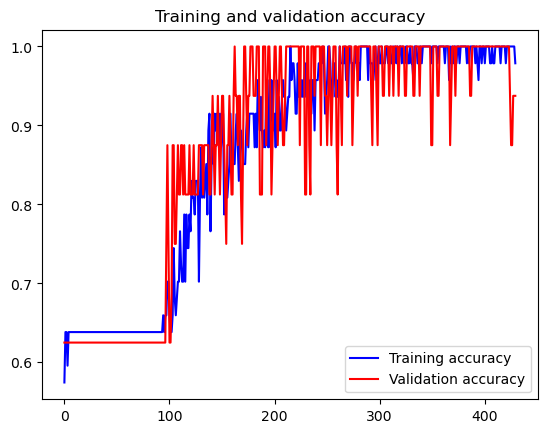

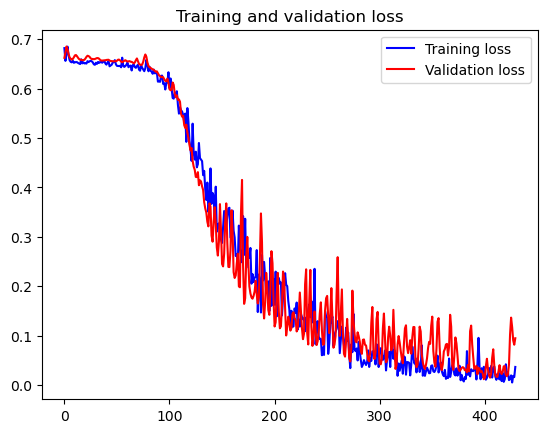

In [41]:
# Plot the training history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [42]:
output_test = model_cnn.predict(X_test)

1/1 [==============================] - 0s 114ms/step


In [43]:
pred_test = np.argmax(output_test,axis=-1)
truth_test = np.argmax(y_test,axis=-1)

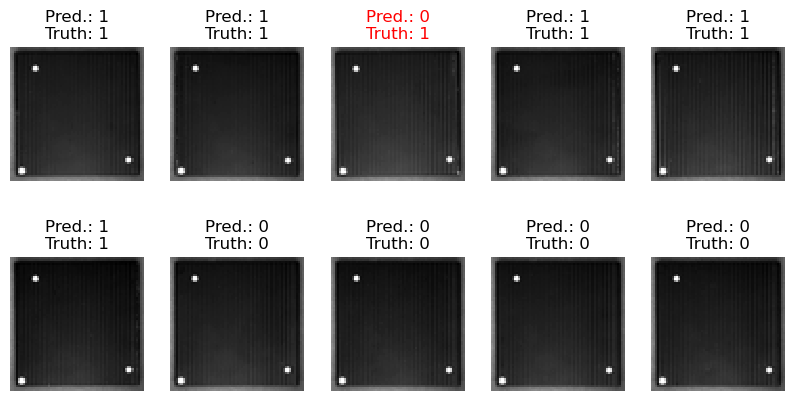

In [44]:
# Visualize the first 30 test samples and show their predicted digit value in the title.
_,axes = plt.subplots(nrows = 2,ncols = 5, figsize= (10,5))
for r in range(2):
    for c in range(5):
        index = r*5 + c
        axes[r,c].set_axis_off()
        image = X_test[index].reshape((width,height))
        pred_label = pred_test[index]
        true_label = truth_test[index]
        axes[r,c].imshow(image, cmap = 'gray', interpolation = "nearest")
        if pred_label == true_label:
            axes[r,c].set_title(f"Pred.: {pred_label}\nTruth: {true_label}")
        else:
            axes[r,c].set_title(f"Pred.: {pred_label}\nTruth: {true_label}",color = 'red')

Text(0.5, 0.98, 'Number occurrences of each class on test set')

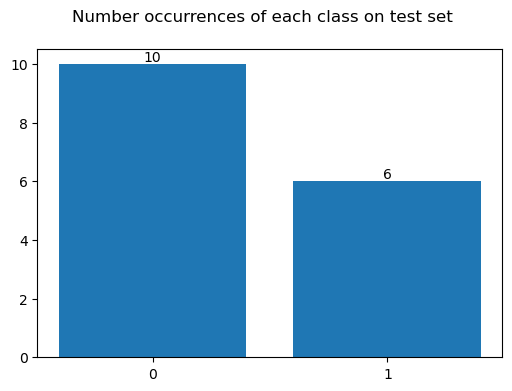

In [45]:
nb_classes = len(np.unique(truth_test))
## Visual bar plot of number occurrences of each class in testset:
statistic_class = np.unique(truth_test,return_counts=True)
categoricalClasses = [f'{C}' for C in statistic_class[0]]
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.bar(x = categoricalClasses, height = statistic_class[1],width = 0.8)
for i in range(nb_classes):
    ax.text(categoricalClasses[i],statistic_class[1][i],
            str(statistic_class[1][i]),ha='center',va = 'bottom')
fig.suptitle("Number occurrences of each class on test set")

In [46]:
# Classification report:
print(f"Classification report for classifier {model_cnn}:\n"
      f"{metrics.classification_report(truth_test,pred_test,digits=4)}\n")

Classification report for classifier <keras.engine.sequential.Sequential object at 0x000001CFD4AED330>:
              precision    recall  f1-score   support

           0     0.9091    1.0000    0.9524        10
           1     1.0000    0.8333    0.9091         6

    accuracy                         0.9375        16
   macro avg     0.9545    0.9167    0.9307        16
weighted avg     0.9432    0.9375    0.9361        16




In [47]:
filters, biases = model_cnn.layers[0].get_weights()

In [48]:
biases.shape

(32,)

In [49]:
filters.shape

(5, 5, 1, 32)

In [50]:
for layer in model_cnn.layers:
    print(layer.name)

conv2d_2
activation
max_pooling2d_2
dropout_2
conv2d_3
activation_1
max_pooling2d_3
dropout_3
flatten_1
dense_2
dense_3


In [57]:
layer0 = Model(inputs=model_cnn.inputs, outputs=model_cnn.layers[0].output)
layer1 = Model(inputs=model_cnn.inputs, outputs=model_cnn.layers[1].output)
layer2 = Model(inputs=model_cnn.inputs, outputs=model_cnn.layers[2].output)

In [59]:
layer0.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2_input (InputLayer)  [(None, 64, 64, 1)]      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 32)        832       
                                                                 
Total params: 832
Trainable params: 832
Non-trainable params: 0
_________________________________________________________________


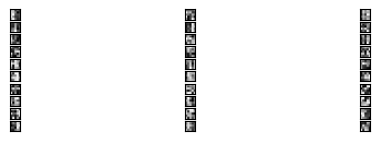

In [52]:
n_filters, ix = 30, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(1):
    # specify subplot and turn of axis
        ax = plt.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
    # plot filter channel in grayscale
        plt.imshow(f[:, :, j], cmap='gray')
    ix += 1
# show the figure
plt.show()

In [53]:
filters[:,:,0,3]

array([[-0.03522406, -0.01425597,  0.07262112,  0.00933342, -0.06293882],
       [-0.04380843, -0.07210039,  0.10368826, -0.0437952 , -0.06586768],
       [-0.0592984 , -0.08858844,  0.11737029, -0.0906778 , -0.00318263],
       [-0.00926511,  0.03296492,  0.14488883, -0.13339506, -0.05049528],
       [ 0.06410828,  0.07833058,  0.24144194, -0.00245092, -0.01194335]],
      dtype=float32)

In [60]:
print(X_test.shape)

(16, 64, 64, 1)


In [67]:
feature_maps0 = layer0.predict(X_test[:1,:,:,:])
feature_maps1 = layer1.predict(X_test[:1,:,:,:])
feature_maps2 = layer2.predict(X_test[:1,:,:,:])

1/1 [==============================] - 0s 76ms/step


In [70]:
feature_maps2.shape

(1, 30, 30, 32)

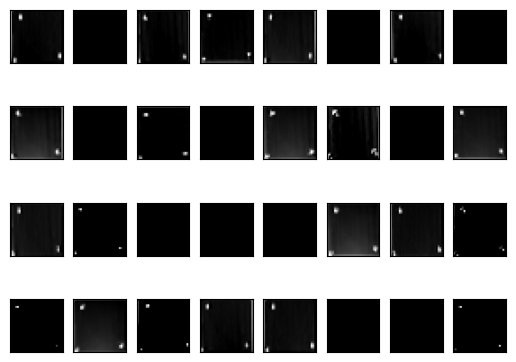

In [69]:
ix = 1
for _ in range(4):
    for _ in range(8):
 # specify subplot and turn of axis
        ax = plt.subplot(4, 8, ix)
        ax.set_xticks([])
        ax.set_yticks([])
    # plot filter channel in grayscale
        plt.imshow(feature_maps2[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
plt.show()

In [75]:
input_shape_test=(1856,1856,1)
model_layer0 = Sequential()
## Convolution layer1 : Conv2d => MaxPool2D => Dropout
model_layer0.add(Conv2D(32,
                    kernel_size=(5,5),
                    input_shape = input_shape_test))

In [76]:
	
model_layer0.set_weights(model_cnn.layers[0].get_weights())

In [80]:
data = []
for i in range(len(list_imgs_test)):
    path_img = list_imgs_test[i]
    img = Image.open(path_img).convert('L')
    data.append(np.array(img))
sample_tensor = np.array(data)

In [81]:
n_samples_tensor = sample_tensor.shape[0]
sample_tensor = sample_tensor.reshape((n_samples_tensor,1856,1856,n_channels))
print(sample_tensor.shape)

(16, 1856, 1856, 1)


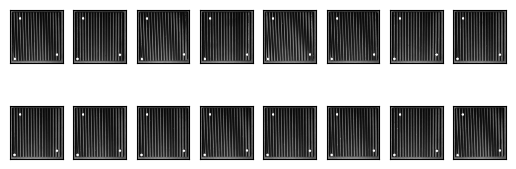

In [86]:
ix = 1
for _ in range(2):
    for _ in range(8):
 # specify subplot and turn of axis
        ax = plt.subplot(4, 8, ix)
        ax.set_xticks([])
        ax.set_yticks([])
    # plot filter channel in grayscale
        plt.imshow(data[ix-1], cmap='gray')
        ix += 1
# show the figure
plt.show()

In [87]:
feature_0 = model_layer0.predict(sample_tensor[:1,:,:,:])

1/1 [==============================] - 0s 247ms/step


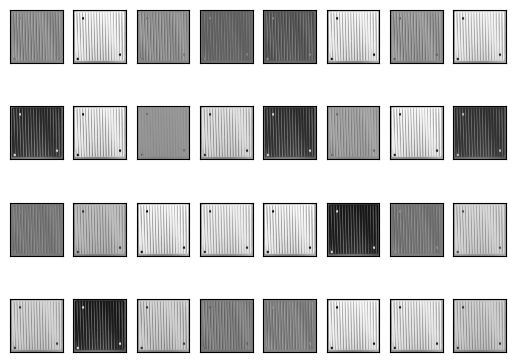

In [88]:
ix = 1
for _ in range(4):
    for _ in range(8):
 # specify subplot and turn of axis
        ax = plt.subplot(4, 8, ix)
        ax.set_xticks([])
        ax.set_yticks([])
    # plot filter channel in grayscale
        plt.imshow(feature_0[0, :, :, ix-1], cmap='gray')
        ix += 1
# show the figure
plt.show()